In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import zscore
import re

# Análise Exploratória Inicial

In [202]:
dados = pd.read_excel("C:\Projetos Pessoais\DataScience\segmentacao_Clientes_Ecomerce\data\Vendas_Varejo_Online.xlsx")

In [203]:
dados.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [204]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [205]:
dados.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [206]:
# Valores NaN
dados.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [207]:
# Dados únicos
dados.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [208]:
dados.shape

(541909, 8)

# Linhas gerais de raciocínio

- invoiceNO que começa com a letra "C" significa cancelamentos
- Para os campos NaN em CostumerID, irei preencher o mesmo código quando a data e hora for igual
- Criação do campo "valor total", multiplicando valor unitario e quantidade
- Criar plotagem no Plotly para Países
- Séries Temporais para as vendas em cada país, expostas no plotly
- Dividir campo data e hora e realizar preenchimento
- Total de 9.291 transações canceladas
- Total de 1.454 de trasanções zeradas com NaN na descrição
- Total de 587 valores unitários = 0

# Engenharia de Atributos

- Como o dataset possui muitos erros que impactariam a EDA, farei a engenharia de atributos antes de analisar a fundo a os dados, para corrigir falhas mais visíveis e melhorar o formato dos dados

#### Exclusão dos itens cancelados "C" e "A"

In [209]:
# Exclusão letra 'C' no 'InvoiceNo'

mask = dados['InvoiceNo'].str.contains('C')
mask = np.where(mask.isna(), False, mask)
mask_C = np.where(mask == True, False, True)

In [210]:
dados = dados[mask_C]

In [211]:
dados.shape

(532621, 8)

In [212]:
# Retirando invoiceNo que contenha "A"

mask_A = dados['InvoiceNo'].str.contains('A')
mask_A2 = np.where(mask_A.isna(), False, mask_A)
mask_A3 = np.where(mask_A2 == True, False, True)
dados = dados[mask_A3]

In [213]:
dados.shape

(532618, 8)

In [214]:
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [215]:
dados['InvoiceDate'][0].value

1291191960000000000

In [216]:
dados['InvoiceDate'][100].value

1291196220000000000

In [217]:
dados['InvoiceDate'][2].value

1291191960000000000

In [218]:
dados['InvoiceDate'][0].value == dados['InvoiceDate'][1].value

True

In [219]:
# Dados ausentes na variável Customer
dados['CustomerID'].isna().sum()

134694

In [220]:
dados['CustomerID'].max()

18287.0

#### Preenchendo valores ausentes da seguinte maneira: 
- Se a compra foi realizada na mesma data e horário da compra anterior, subtende-se que foram realizadas pelo mesmo cliente;
- No momento em que o horário mudar, o código de cliente gerado também mudará
- Como o maior código de cliente é 18287, usarei códigos a partir de 19000


In [221]:
dados

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [222]:
# Função para preenchimento dos clientes NaN

def preencher_customer_id(df):
    codigo_cliente = 19000
    
    # Redefinir o índice do DataFrame
    df = df.reset_index(drop=True)
    
    for indice, linha in df.iterrows():
        if pd.isna(linha['CustomerID']):
            if indice == 0 or linha['InvoiceDate'] != df.loc[indice - 1, 'InvoiceDate']:
                codigo_cliente += 1
            df.at[indice, 'CustomerID'] = codigo_cliente
    return df

# Aplicar a função ao DataFrame
dados_customer = preencher_customer_id(dados)

In [223]:
dados['CustomerID'].isna().sum()

134694

In [224]:
dados_customer['CustomerID'].isna().sum()

0

In [225]:
dados.CustomerID[300426]

nan

In [226]:
dados_customer.CustomerID[300426]

14221.0

In [227]:
# Verificando os novos códigos gerados 
dados_customer[dados_customer['CustomerID'] > 18999]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
613,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,19001.0,United Kingdom
1431,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,19002.0,United Kingdom
1432,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,19002.0,United Kingdom
1433,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,19002.0,United Kingdom
1434,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,19002.0,United Kingdom
...,...,...,...,...,...,...,...,...
532249,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,21825.0,United Kingdom
532250,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,21825.0,United Kingdom
532251,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,21825.0,United Kingdom
532252,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,21825.0,United Kingdom


### Retirando os NaN de Descrição, pois em todos o valor unitário do material é 0

In [228]:

mascara = dados_customer['Description'].isna()
mascara2 = np.where(mascara == False, True, mascara)

# Aplicando a mascara
dados_semNA = dados_customer

dados_semNA.dropna(subset=['Description'], inplace=True)
dados_semNA.shape

(531164, 8)

In [229]:
dados_semNA['CustomerID'] = dados_semNA['CustomerID'].astype(int)
dados_semNA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531164 entries, 0 to 532617
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531164 non-null  object        
 1   StockCode    531164 non-null  object        
 2   Description  531164 non-null  object        
 3   Quantity     531164 non-null  int64         
 4   InvoiceDate  531164 non-null  datetime64[ns]
 5   UnitPrice    531164 non-null  float64       
 6   CustomerID   531164 non-null  int32         
 7   Country      531164 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 34.4+ MB


In [230]:
# Criando Nova coluna com os valores totais de cada transação
dados_semNA['Valor_total'] = dados_semNA['Quantity'] * dados_semNA['UnitPrice']

In [231]:
dados_semNA

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Valor_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
532613,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
532614,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
532615,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
532616,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


### Criando um novo campo para a hora de venda e deixando apenas o dia da venda no campo invoiceDate

- Objetivo é verificar em quais horários as vendas tem maiores volumes
- Verificar tambem, com gráficos do Plotly, o volume de vendas dos paises por dia

In [232]:
# Campo de horário
dados_semNA['Horario_Venda'] = dados_semNA['InvoiceDate'].dt.time

In [233]:
# Campo de data
dados_semNA['Data_Venda'] = dados_semNA['InvoiceDate'].dt.date
dados_semNA = dados_semNA.drop('InvoiceDate', axis = 1)

In [234]:
dados_semNA.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Valor_total,Horario_Venda,Data_Venda
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,08:26:00,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,08:26:00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01


In [235]:
dados_semNA.isna().sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
UnitPrice        0
CustomerID       0
Country          0
Valor_total      0
Horario_Venda    0
Data_Venda       0
dtype: int64

In [236]:
# Excluindo variável 'InvoiceNo', pois não terá serventia
dados_semNA = dados_semNA.drop('InvoiceNo', axis = 1)

In [237]:
dados_semNA

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Valor_total,Horario_Venda,Data_Venda
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,08:26:00,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,08:26:00,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
...,...,...,...,...,...,...,...,...,...
532613,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,10.20,12:50:00,2011-12-09
532614,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,12.60,12:50:00,2011-12-09
532615,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,16.60,12:50:00,2011-12-09
532616,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,16.60,12:50:00,2011-12-09


In [238]:
# Renomenando as variáveis
rename = {
    'StockCode': 'Codigo',
    'Description': 'Descricao',
    'Quantity': 'Quantidade',
    'UnitPrice': 'Valor_unitario',
    'CustomerID': 'Cod_cliente',
    'Country': 'Pais',
    'Valor_total': 'Valor_total',
    'Horario_Venda': 'Horario_venda',
    'Data_Venda': 'Data_venda'
}
dados_semNA.rename(columns = rename, inplace = True)

In [239]:
dados_semNA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531164 entries, 0 to 532617
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Codigo          531164 non-null  object 
 1   Descricao       531164 non-null  object 
 2   Quantidade      531164 non-null  int64  
 3   Valor_unitario  531164 non-null  float64
 4   Cod_cliente     531164 non-null  int32  
 5   Pais            531164 non-null  object 
 6   Valor_total     531164 non-null  float64
 7   Horario_venda   531164 non-null  object 
 8   Data_venda      531164 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 38.5+ MB


In [240]:
dados_semNA.describe()

,Quantidade,Valor_unitario,Cod_cliente,Valor_total
count,531164.000000,531164.000000,531164.000000,531164.00000
mean,10.293676,3.879001,16583.395345,20.06089
std,159.301807,32.514222,2715.090294,269.66306
min,-9600.000000,0.000000,12346.000000,-0.00000
25%,1.000000,1.250000,14388.000000,3.75000
50%,3.000000,2.080000,16270.000000,9.90000
75%,10.000000,4.130000,19002.000000,17.70000
max,80995.000000,13541.330000,21825.000000,168469.60000


In [241]:
# Verificando as quantidades negativas
mask_quantidade = dados_semNA['Quantidade'] < 0
mask_quantidade = np.where(mask_quantidade == False, True, False)
data = dados_semNA[mask_quantidade]

In [242]:
data

,Codigo,Descricao,Quantidade,Valor_unitario,Cod_cliente,Pais,Valor_total,Horario_venda,Data_venda
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,08:26:00,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,08:26:00,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
...,...,...,...,...,...,...,...,...,...
532613,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,10.20,12:50:00,2011-12-09
532614,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,12.60,12:50:00,2011-12-09
532615,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,16.60,12:50:00,2011-12-09
532616,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,16.60,12:50:00,2011-12-09


In [243]:
# verificando informações e describe
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530690 entries, 0 to 532617
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Codigo          530690 non-null  object 
 1   Descricao       530690 non-null  object 
 2   Quantidade      530690 non-null  int64  
 3   Valor_unitario  530690 non-null  float64
 4   Cod_cliente     530690 non-null  int32  
 5   Pais            530690 non-null  object 
 6   Valor_total     530690 non-null  float64
 7   Horario_venda   530690 non-null  object 
 8   Data_venda      530690 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 38.5+ MB


In [244]:
data.describe()

,Quantidade,Valor_unitario,Cod_cliente,Valor_total
count,530690.000000,530690.000000,530690.000000,530690.000000
mean,10.605873,3.882466,16579.562340,20.078808
std,156.638294,32.528533,2713.172403,269.782795
min,1.000000,0.000000,12346.000000,0.000000
25%,1.000000,1.250000,14387.000000,3.750000
50%,3.000000,2.080000,16265.000000,9.900000
75%,10.000000,4.130000,19002.000000,17.700000
max,80995.000000,13541.330000,21825.000000,168469.600000


In [245]:
# Retirando transações com valor unitário igual a 0
mask_valor = data['Valor_unitario'] == 0
mask_valor = np.where(mask_valor == False, True, False)
data_final = data[mask_valor]

In [246]:
data_final

,Codigo,Descricao,Quantidade,Valor_unitario,Cod_cliente,Pais,Valor_total,Horario_venda,Data_venda
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,08:26:00,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,08:26:00,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
...,...,...,...,...,...,...,...,...,...
532613,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,10.20,12:50:00,2011-12-09
532614,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,12.60,12:50:00,2011-12-09
532615,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,16.60,12:50:00,2011-12-09
532616,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,16.60,12:50:00,2011-12-09


In [247]:
print(data_final.info())
print(data_final.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 530103 entries, 0 to 532617
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Codigo          530103 non-null  object 
 1   Descricao       530103 non-null  object 
 2   Quantidade      530103 non-null  int64  
 3   Valor_unitario  530103 non-null  float64
 4   Cod_cliente     530103 non-null  int32  
 5   Pais            530103 non-null  object 
 6   Valor_total     530103 non-null  float64
 7   Horario_venda   530103 non-null  object 
 8   Data_venda      530103 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 38.4+ MB
None
          Quantidade  Valor_unitario    Cod_cliente    Valor_total
count  530103.000000   530103.000000  530103.000000  530103.000000
mean       10.542055        3.886765   16576.019883      20.101042
std       155.524270       32.546281    2711.936293     269.931295
min         1.000000        0.001000   1234

## Verificação dos dados de Stock Code

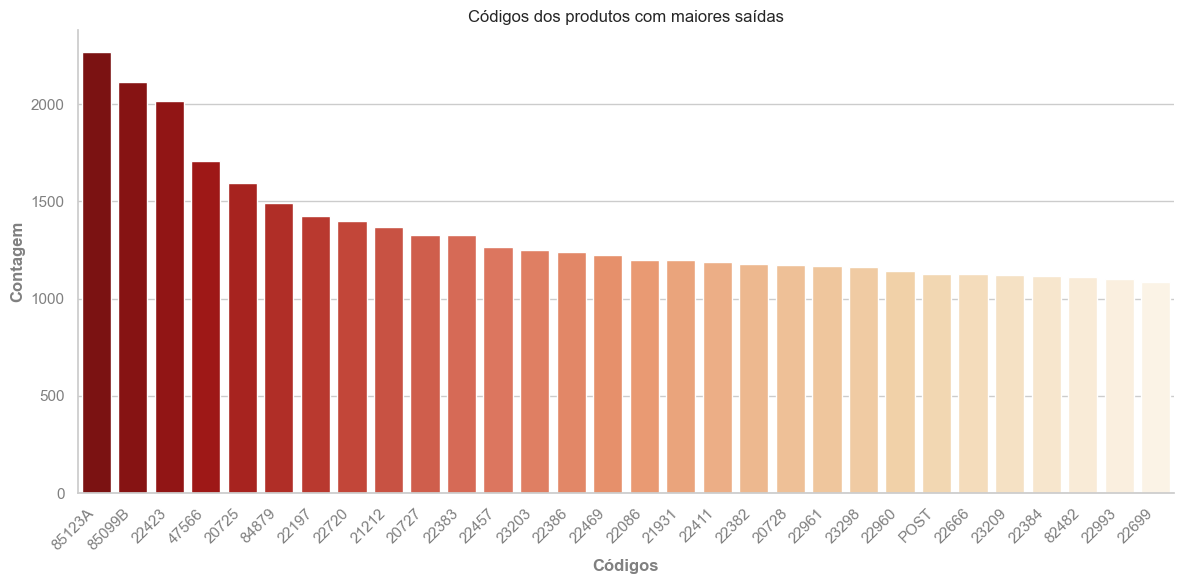

In [248]:
top_20_codigos = data_final['Codigo'].value_counts().head(30)

sns.set(style="whitegrid")

# plotagem
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_codigos.index, y=top_20_codigos.values, palette="OrRd_r")
plt.title('Códigos dos produtos com maiores saídas')
plt.xlabel('Códigos', color = 'grey', fontweight='bold')
plt.ylabel('Contagem', color = 'grey', fontweight='bold')
plt.xticks(rotation=45, ha='right', color = 'grey')
plt.yticks(color = 'grey')
plt.tight_layout()

# retira bordas
sns.despine(right=True, top=True)

plt.show()

In [249]:
data_final['Codigo'].sample(20)

238948     22355
40662      22984
137889     22192
3457       22086
132600     21137
243083     22031
201301     48116
202530     22728
91414      21930
411750     23245
135485     22291
21467     85123A
194442     84978
378564     82552
41365      22444
4426       84692
66696      82583
407396     23554
418761     20723
455865    85169C
Name: Codigo, dtype: object

## Como pode-se ver, o padrão dos dos valores são:
- Código com 5 números
- Código com 5 números e 1 letra

Com isso, irei verificar se existem códigos que sejam diferentes destes padrões

In [250]:
result = (data_final['Codigo'].str.len() > 6) | (data_final['Codigo'].str.len() < 5)
result.value_counts()

dados_teste2 = data_final[result]
dados_teste2.Codigo.value_counts()

Codigo
POST            1126
DOT              706
M                321
15056BL          321
C2               141
15056bl           62
DCGSSGIRL         13
BANK CHARGES      12
DCGSSBOY          11
gift_0001_20       9
gift_0001_10       8
gift_0001_30       7
gift_0001_50       4
DCGS0003           4
gift_0001_40       3
PADS               3
AMAZONFEE          2
DCGS0076           2
S                  2
DCGS0070           1
DCGS0069           1
m                  1
DCGS0004           1
Name: count, dtype: int64

### Valores Discrepantes: 
- POST: POSTAGE
- DOT: DOTCOM POSTAGE
- M: Manual
- C2: CARRIAGE
- BANK CHARGES: Bank Charges
- AMAZONFEE: AMAZON FEE
- S: SAMPLES
- m: Manual

Com essa informação, irei excluir as transações que possuem os valores acima, pois se referem a taxas administrativas de envio, não ao produto, o que foje ao escopo do projeto

In [251]:
# Excluindo as linhas

valores_excluir = ['POST', 'DOT', 'M', 'C2', 'BANK CHARGES', 'AMAZONFEE', 'S', 'm']
mascara_codigo = data_final['Codigo'].isin(valores_excluir)
mascara_codigo2 = np.where(mascara_codigo == False, True, False)
data_final = data_final[mascara_codigo2]
data_final.shape

(527792, 9)

In [252]:
data_final

,Codigo,Descricao,Quantidade,Valor_unitario,Cod_cliente,Pais,Valor_total,Horario_venda,Data_venda
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30,08:26:00,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00,08:26:00,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,08:26:00,2010-12-01
...,...,...,...,...,...,...,...,...,...
532613,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,10.20,12:50:00,2011-12-09
532614,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,12.60,12:50:00,2011-12-09
532615,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,16.60,12:50:00,2011-12-09
532616,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,16.60,12:50:00,2011-12-09


## Salvando em disco o dataset final e com todas as alterações de Eng Atributos 

In [253]:
# Salvando DF
data_final.to_csv('../data/dados_limpos_pre_EDA.csv', sep =',', index = False, encoding = 'utf-8')